<img src='img/banner.png' align='right' width='100%'></img>

<div class="alert alert-block alert-success">
<b>PREREQUISITE </b><br>
    
For smooth experience some actions are needed:
* It is expected for user to be familiar with Python.

# Calculation of Fractional Vegetation Cover anomaly from LSA SAF ETFVC



#### About
The [LSA-SAF Fraction of Vegetation Cover (ETFVC)](https://landsaf.ipma.pt/en/data/products/vegetation/) is 10-day Fraction of Vegetation Cover (FVC) retrieval from clear-sky observations performed by AVHRR/Metop. FVC defines an important structural property of a plant canopy, which corresponds to the complement to unity of the gap fraction at nadir direction, accounting for the amount of vegetation distributed in a horizontal perspective. It is relevant for a wide range of Land Biosphere Applications such as agriculture and forestry, environmental management and land use.

In this Jupyter Notebook (JN), we calculate FVC anomaly compared to a reference period (2015-2021). The magnitude of anomalies can serve as an indicator of various abnormal vegetation situations, in this case drought in 2022. Analysis is conducted at selected locations characterized by a well known vegetative ground layer. For each location, corresponding ETFVC pixel value is used for calculating the anomaly.

#### How to access the data

Data will be accesed from the LSA SAF THREDDS Data Server. The acces method will be described in the Jupyter Notebook.

#### Basic facts on the LSA SAF ETFVC
 > **Product number**: LSA-403
 >
 > **Spatial resolution**: 1km at nadir 
 >
 > **Spatial coverage**: Full Globe
 >
 > **Time steps**: 10 day  
 >
 > **Data availability**: from 2015

#### Module outline:
* [1 - Accessing the Data](#First)
* [2 - Calculating Vegetation Anomalies](#Second)
* [3 - Analysis](#Third)

#### Load Required Libraries

<hr>

In [1]:
import matplotlib.pyplot as plt  # a library that provides plotting capability
import datetime as dt  # a library that allows us to work with dates and times
import xarray as xr  # a powerful library that helps us work efficiently with multi-dimensional arrays
import numpy as np  # a library that lets us work with arrays; we import this with a new name "np"
import pandas as pd  # a library for time series analysis
from tqdm import tqdm  # a library to display progress meter with low overhead
from matplotlib.ticker import FixedLocator  # FixedLocator allows specifying fixed tick locations on an axis

# Set the matplotlib backend to inline
%matplotlib inline

# Set the default figure size
plt.rcParams['figure.figsize'] = [13, 8]

#### Define Utility Functions

In this section we will define some functions, to simplify the code and make JN more clear.

In order to automate data access, we first want to define a `get_THREDDS_url()`. It returns a URL address used to access a particular `NetCDF4` file on the THREDDS data server.

Although we are only analysing FVC in this notebook, can be the `get_THREDDS_url()` reused to access other EPS-based vegetation products (FAPAR, FVC) via the THREDDS server, by calling the different `product` argument.

In [2]:
def get_THREDDS_url(date, product, username, password):
    """
    Function returns the URL link to the THREDDS data server.

    Parameters:
        - date (datetime): A datetime object representing the date for which data is requested.
        - product (str): A string indicating the product type. Supported values are "LAI", "FAPAR", or "FVC".
        - username (str): Username for accessing the THREDDS server.
        - password (str): Password for accessing the THREDDS server.

    Returns:
        str: URL link to the THREDDS data server.
    """

    url = (
        "https://"
        + username
        + ":"
        + password
        + "@thredds.lsasvcs.ipma.pt/thredds/dodsC/EPS/ET"
        + product
        + "/NETCDF/"
        + str("{:02d}".format(date.year))
        + "/"
        + str("{:02d}".format(date.month))
        + "/"
        + str("{:02d}".format(date.day))
        + "/"
        + "NETCDF4_LSASAF_M01-AVHR_ET"
        + product
        + "_GLOBE_"
        + str("{:02d}".format(date.year))
        + str("{:02d}".format(date.month))
        + str("{:02d}".format(date.day))
        + "0000.nc"
    )

    return url

To simplify our work, we define a function `get_data()` that extracts the value of the LSA SAF product we intend to analyze. The same function could be used to access a suite of LSA SAF vegetation products (ETFVC, ETFAPAR and ETLAI) via the THREDDS Data Server. The function takes a list of latitudes and longitudes for the satellite pixels of interest. It then returns the list of vegetation values for each pixel.

The function inputs are lists of latitudes and longitudes that represent our points of interest. It opens the desired `NetCDF4` file and extracts values of pixels with the desired latitude and longitude. Detailed instructions on how to index the data within `xarray` can be found [here](https://docs.xarray.dev/en/stable/user-guide/indexing.html).

In [3]:
def get_data(date, product, lat_input, lon_input):
    """
    Loads vegetation data into a dataset and returns values for a point of interest.
    
    Parameters:
    - date: pd.datetime
        The date for which the data is requested.
    - product: string
        The vegetation product to retrieve data for.
        Should be one of: "LAI", "FAPAR", "FVC".
    - lat_input, lon_input: list of floats
        Latitude and longitude coordinates of the point of interest.
    
    Returns:
    - LSA_SAF_value: np.array
        The vegetation product value at the specified points and date.
    """

    # Define a list of points as a data array
    target_lat = xr.DataArray(lat_input, dims="points")
    target_lon = xr.DataArray(lon_input, dims="points")

    # Define dataset
    LSA_SAF_ds = xr.open_dataset(
        get_THREDDS_url(date, product, USER, PASSWD), decode_times=False
    )

    # Extract product values
    LSA_SAF_value = (
        LSA_SAF_ds.sel(lat=target_lat, lon=target_lon, method="nearest")[product]
        .load()
        .values[0]
    )

    # Close the dataset to free the memory
    LSA_SAF_ds.close()

    return LSA_SAF_value

We will also define a function `calculate_climatology()` which calculates a reference value of the desired LSA SAF product for each day. It calculates the reference for a specified vegetation product (e.g., ETLAI, ETFAPAR, ETFVC) at a given location (specified by latitude and longitude coordinates) for a specific day of the year. Reference is defined as an average value of the vegetation index for a particular day of the year, during the predetermined reference period. A list of reference years (`climatology_reference_years`), will be defined later as a global variable.

This function iterates over a set of reference years, retrieves data for a particular day in each reference year using the `get_data()` function, and then calculates the mean of these reference values by using `np.nanmean()`.

In [4]:
def calculate_climatology(date, product, lat_input, lon_input):
    """This function calculates reference (climatology)
    of a selected LSA SAF vegetation product. Years used for calculation of the 
    reference are set as a global variable.

    Parameters:
    - date: pd.datetime
        The date for which the climatology is calculated.
    - product: string
        The vegetation product to calculate climatology for.
        Should be one of: "LAI", "FAPAR", "FVC".
    - lat_input, lon_input: list of floats
        Latitude and longitude coordinates of the location.

    Returns:
    - reference_values: np.array
        The climatology reference values for the specified product and location.
    """

    # Define empty array for results
    reference_values = np.full(
        (len(climatology_reference_years), locations_df.shape[0]), np.nan
    )

    # Iterate over all dates of the interest
    for i in range(len(climatology_reference_years)):
        
        # Extract data
        reference_values[i, :] = get_data(
            date.replace(climatology_reference_years[i].year),
            product,
            lat_input,
            lon_input,
        )

    return np.nanmean(reference_values, axis=0)

### <a id='First'></a>1. Accessing the Data

We set the locations of interest for which we want to calculate the FVC anomaly. Locations are presented as a `pandas.DataFrame` with columns name, latitude, longitude and surface type. Such an approach is used, since `pandas.DataFrame` object can be easily imported from `.csv` or a similar file in case the user would like to calculate FVC anomaly for any other custom locations.

In [5]:
# Dataframe containing locations and descriptions is constructed
locations_df = pd.DataFrame(
    [
        ["SI, Bilje", 45.90333, 13.64980, "Vineyards"],
        ["IT, Ferrara", 44.90420, 11.28128, "Fields"],
        ["PT, Evora", 38.540, -8.003, "Deciduous forest"],
    ],
    columns=["Name", "lat", "lon", "Type"],
)

# Check the dataframe
print(locations_df)

          Name       lat       lon              Type
0    SI, Bilje  45.90333  13.64980         Vineyards
1  IT, Ferrara  44.90420  11.28128            Fields
2    PT, Evora  38.54000  -8.00300  Deciduous forest


The data is accessed from the [LSA SAF THREDDS Data Server (TDS)](https://thredds.lsasvcs.ipma.pt/) through the [OpenDAP protocol](https://gitlab.com/helpdesk.landsaf/lsasaf_data_access/-/wikis/data/thredds). TDS is currently in the demonstration phase. It allows the user to load a subset of a `NetCDF4` file, for instance, a 2D (lat-lon) slice or a list of points in order to reduce transfer and disk space.

This is of significant importance when dealing with satellite products that make up the EUMETSAT Polar System (EPS) series because of the size of the `NetCDF4` files. In the case of the ETFVC product, the size of a single file is approximately 250 MB, which can require a significant amount of available memory when analysing long-term datasets.

Using the TDS to load specific data subsets enables faster processing of larger files. In order to access the data, one first needs to [register](https://gitlab.com/helpdesk.landsaf/lsasaf_data_access/-/wikis/credentials/register). Some examples of how to access TDS are already [available](https://gitlab.com/helpdesk.landsaf/lsasaf_data_access/-/wikis/data/thredds), while the documentation is available [here](https://www.unidata.ucar.edu/software/tds/). Data can be accessed with a prior registration [here](https://thredds.lsasvcs.ipma.pt/thredds/catalog/catalog.html).

First one needs to define username and password:

In [6]:
USER="***"
PASSWD="***"

We will use `xarray.open_dataset()` to define a remote dataset accessible over TDS. The location of the dataset needs to be specified as an URL address as follows: `https://<USERNAME>:<PASSWORD>@thredds.lsasvcs.ipma.pt/thredds/dodsC/<satellite>/<product>/<format>/<year>/<month>/<day>/filename`.

We define the `xarray.DataSet`. The `xarray` library uses lazy load, therefore the data will be loaded, when we use `DataSet.load()` or call the data in the dataset. A detailed description of the process is available in the [xarray User Guide](https://docs.xarray.dev/en/stable/user-guide/data-structures.html).

What follows, is an example for accessing the ETFVC data for May 5, 2022. This day was choosen, since vegetation in Europe is usually already developed in May, therefore this date offers a representative demonstration of ETFVC product over Europe.

In [7]:
# Define the dataset

test_ds = xr.open_dataset(
    "https://"
    + USER
    + ":"
    + PASSWD
    + "@thredds.lsasvcs.ipma.pt/thredds/dodsC/EPS/ETFVC/NETCDF/2022/05/05/NETCDF4_LSASAF_M01-AVHR_ETFVC_GLOBE_202205050000.nc"
)

print(test_ds)

<xarray.Dataset>
Dimensions:         (lat: 18001, lon: 36000, time: 1)
Coordinates:
  * lat             (lat) float32 -90.0 -89.99 -89.98 ... 89.98 89.99 90.0
  * lon             (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time            (time) datetime64[ns] 2022-05-05
Data variables:
    crs             |S64 ...
    FVC             (time, lat, lon) float32 ...
    Z_Age           (time, lat, lon) float32 ...
    quality_flag    (time, lat, lon) float32 ...
    standard_error  (time, lat, lon) float32 ...
Attributes: (12/29)
    references:                      Data provided by the EUMETSAT Satellite ...
    easternmost_longitude:           -180.0
    westernmost_longitude:           179.989990234375
    spatial_resolution:               0.01x 0.01
    geospatial_lat_units:            degrees_north
    geospatial_lon_units:            degrees_east
    ...                              ...
    geospatial_lat_resolution:        0.01
    geospatial_lon_resolution:       

Now we can look into the actual data and simple data slicing in `xarray`. The data for EPS-based LSA SAF products are available for latitudes from -90° to 90° and longitudes from -180° to 180˚. We will define a rectangle with longitudes between 10˚ W and 50° E and latitudes between 20° N and 50° N by indexing with dimension names with the `sel()` method. A detailed description of the approach is available [here](https://docs.xarray.dev/en/stable/user-guide/indexing.html).

We can then plot the selected subset of the data using [xarray pyplot wrapper](https://docs.xarray.dev/en/stable/user-guide/plotting.html) by calling `Dataset.variable.plot()`. The resulting plot shows the vegetation conditions in Europe at the end of spring.  It can be observed, that the the desert regions in North Africa are completely without active vegetation (FVC near 0), while the regions in central Europe exhibit quite a lot of vegetation. It is worth noting that the quality of measurements (e.g., due to weather) decreases in Northern Europe, therefore FVC wasn't evaluated for all pixels in Northern Europe, such as Scandinavia and parts of the United Kingdom and Ireland.

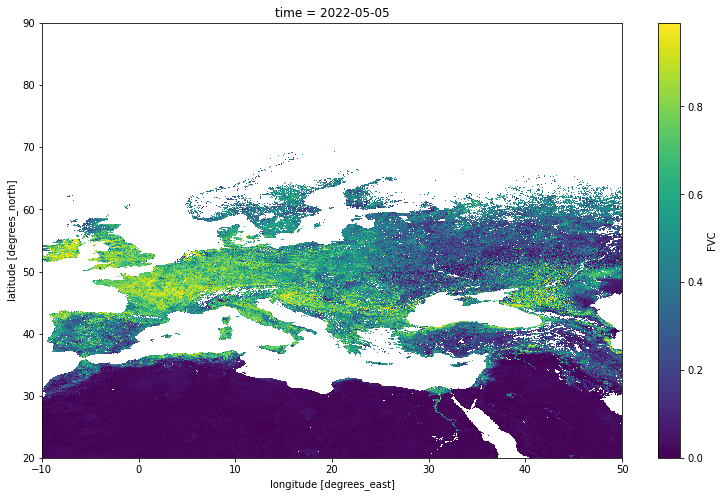

In [8]:
# Define a slice of the NetCDF4 file
test_ds = test_ds.sel(lat=slice(20, 90), lon=slice(-10, 50))

# Plot the slice
test_ds.FVC.plot()

# Close the dataset to save the memory
test_ds.close()

### <a id='Second'></a>2. Calculating Vegetation Anomalies


In order to calculate FVC anomaly for our locations of interest, we first need to calculate reference (average) values over several years of data.  In the case of the LSA SAF ETFVC product, the data is available from 2015, which somewhat limits the number of years used for calculation of the climatology (reference values). In the example presented here, the period 2015-2021 is used as reference.
 
We will calculate the FVC anomaly for the pre-defined range of dates and then calculate reference by averaging the FVC estimations for the same day and month but different years.

We will define all these ranges of dates (range for FVC estimation, range of years used to calculate reference) and define an empty `numpy.array` to store our results.

Since EPS products are available every 10 days (5th, 15th and 25th days of each month) we first construct a list of dates by `pandas.date_range()` for the whole year and then filter out dates that are not needed (we keep only the days 5, 15 and 25 of each month).

In [9]:
# Set start and end date
start_date = dt.datetime(2022, 1, 1, 0, 0, 0)
end_date = dt.datetime(2022, 12, 31, 0, 0, 0)

# A list of days of interest is generated.
date_range = pd.date_range(start_date, end_date, freq="1d")

# Filter out the date range - allow only days 5, 15, 25
date_range = date_range[
    (date_range.day == 5) | (date_range.day == 15) | (date_range.day == 25)
]

# Define the start and the end of climatology
climatology_start = dt.datetime(2015, 1, 1)
climatology_end = dt.datetime(2021, 12, 31)

# Define a range of years for climatology
climatology_reference_years = pd.date_range(
    climatology_start, climatology_end, freq="1Y"
)

# Define empty arrays for results
product_values = np.full((locations_df.shape[0], len(date_range)), np.nan)
climatology_values = np.full((locations_df.shape[0], len(date_range)), np.nan)

The function `get_data` will be used to access the actual measurements at certain locations. This function could return an error in case of missing data or problems with the internet connection, therefore it is recommended to keep track of potential errors. It is recommended to call this function with `try` and `except` to avoid cell execution stopping when an error occurs.

If printing of error messages is needed, it can be achieved by setting the PRINT_ERROR parameter to `True`. We tend to avoid that for the sake of clarity, therefore, by default, PRINT_ERROR is set to `False`.

In [10]:
PRINT_ERROR=False

We will show how to use the function `get_data()` in the next cell. We will iterate over all days of interest defined in the `date_range`. For each day, we get FVC values for all locations of interest in a single call of the function. We store the result in the `numpy.array` since it allows multidimensional indexing and therefore offers a fast way to directly save the output of the `get_data()` function.

The `try` and `except` commands are used in order to avoid interrupting the `for` loop in case of missing data. In case of exceptions, an error is printed if the `PRINT_ERROR` was set to `True`.

In [11]:
# Loop over datetime objects
for i, date in tqdm(enumerate(date_range)):

    try:

        # Call get_data() to extract FVC and save it in the numpy array
        product_values[:, i] = get_data(
            date, "FVC", locations_df["lat"], locations_df["lon"]
        )

    # Handle exceptions
    except Exception as e:
        if PRINT_ERROR:
            print(e)
            print("Missing date" + str(date))

0it [00:00, ?it/s]

36it [00:45,  1.26s/it]


We can do a quick visualization of the FVC values. The following code iterates over all locations defined at the beginning and plots FVC for each location over a specified date range. The plot is customized by adding a legend and setting labels, axes as well as a title.

Text(0.5, 1.0, 'Fractional Vegetation Cover (FVC) \n Range: [0, 1]')

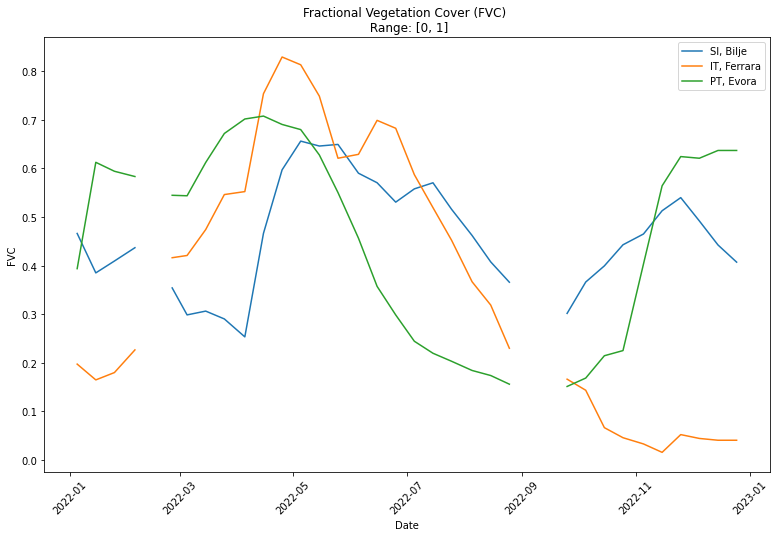

In [12]:
# Iterate over all locations
for j in range(locations_df.shape[0]):

    # Plot FVC for current location
    plt.plot(
        date_range.to_list(), product_values[j, :], label=locations_df["Name"].iloc[j]
    )

# Customize the plot
plt.legend()
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("FVC")
plt.title("Fractional Vegetation Cover (FVC) \n Range: [0, 1]")

Now we will aslo calculate climatology wiht the help of `calculate_climatology()` function. We will iterate over the days of interest, for which we have already determined the FVC data. Similarly to before, the outputs are stored in a `numpy.array`.

In [13]:
# Loop over the dates of the interest
for i, date in tqdm(enumerate(date_range)):


        try:
                # Calculate climatology reference by caling caculate_climatology()                      
                climatology_values[:, i]=calculate_climatology(date, "FVC", locations_df["lat"], locations_df["lon"])
        
        # Handle exceptions
        except Exception as e:
            if PRINT_ERROR:
                print(e)
                print("Missing date" + str(date))

2it [00:00,  4.15it/s]

36it [05:21,  8.93s/it]


In a similar manner as before with the FVC values, we may also visualize the reference.
The code iterates over all pre-defined locations and plots the FVC reference for each location. The plot that we obtain is further customized by adding a legend and setting labels for the x and y axis as well as a title.

Text(0.5, 1.0, 'Fractional Vegetation Cover (FVC) climatology \n Range: [0, 1]')

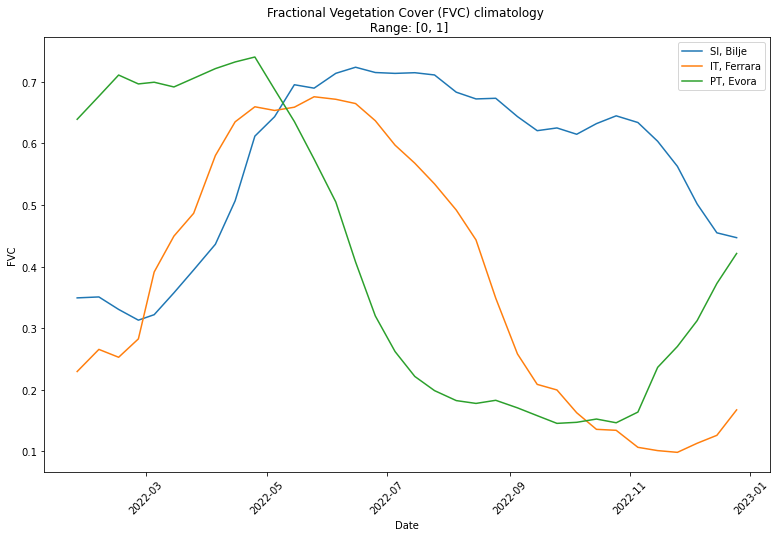

In [14]:
# Iterate over all locations
for j in range(locations_df.shape[0]):

    # Plot FVC climatology for current location
    plt.plot(date_range.to_list(), climatology_values[j,:], label=locations_df["Name"].iloc[j])

# Customize the plot
plt.legend()
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("FVC")
plt.title("Fractional Vegetation Cover (FVC) climatology \n Range: [0, 1]")

### <a id='Third'></a>3. Analysis

We will plot the yearly FVC evolution in 2022 at three locations in the Mediterranean where drought occurred in 2022. Our hypothesis is that the drought will be evident in the form of lower FVC values compared to the reference that was based on multi-year dataset.

The code in the next cell plots FVC in 2022 at each location together with the corresponding reference for each location. Reference and FVC values for the same location are shown on the same subplot.

Code is designed in a way, that is able to accommodate additional locations by adding additional entries in `locations_df` dataset defined at the beginning of this notebook.

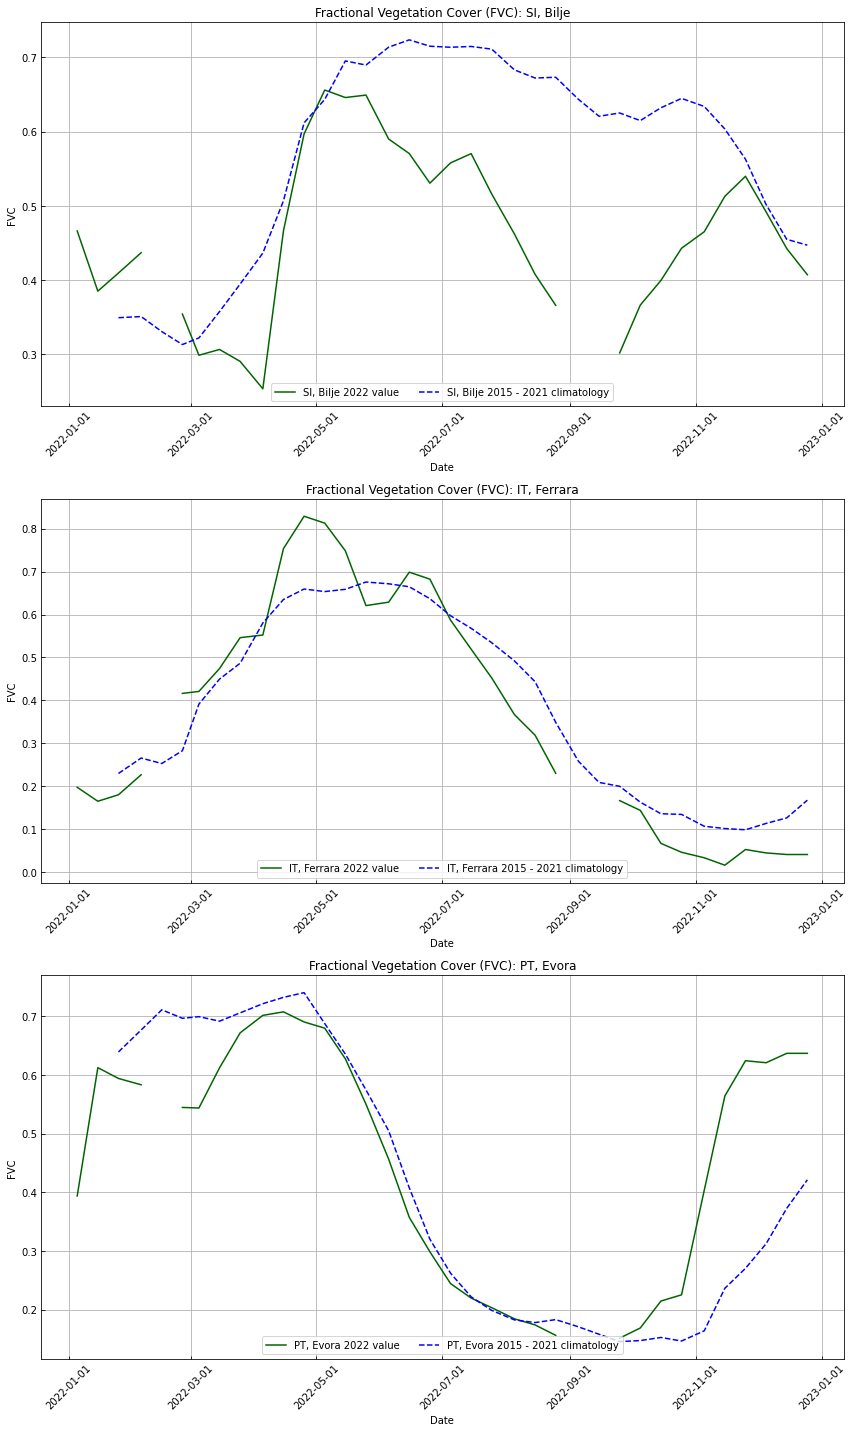

In [15]:
# Define figure and subplots
fig, ax = plt.subplots(locations_df.shape[0], 1, figsize=(12, 20))

# Flaten ax array, to simplify iteration
ax = ax.flatten()

# for loop over all locations:
for j in range(locations_df.shape[0]):

    # Plot data
    ax[j].plot(
        date_range.to_list(),
        product_values[j, :],
        label=locations_df["Name"].iloc[j] + " {} value".format(start_date.year),
        color="darkgreen",
        linestyle="solid",
    )

    # Plot climatology
    ax[j].plot(
        date_range.to_list(),
        climatology_values[j, :],
        label=locations_df["Name"].iloc[j]
        + " {} - {} climatology".format(climatology_start.year, climatology_end.year),
        color="blue",
        linestyle="dashed",
    )

    # Customize plot

    # Set ticks (major formatter must be used together with major locator)
    ax[j].tick_params(axis="both", direction="in")
    ticks = ax[j].get_xticks()
    ax[j].xaxis.set_major_locator(FixedLocator(ticks))
    ax[j].set_xticklabels(ticks, rotation=45)
    ax[j].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y-%m-%d"))

    # Set legend and grid
    ax[j].legend(ncol=2, loc="lower center")
    ax[j].grid()

    # Set title
    ax[j].set_title(
        "Fractional Vegetation Cover (FVC): " + locations_df["Name"].iloc[j]
    )

    # Set labels
    ax[j].set_xlabel("Date")
    ax[j].set_ylabel("FVC")

# Tight layout to avoid overlaps of the subplots
plt.tight_layout()

In Bilje, Slovenia, a notable deviation from the reference (climatology) can be observed from May to September, which is in line with the drought in the southwestern region of Slovenia that occurred in 2022. This drought resulted in significant damage to agriculture. It was estimated to approximately [150 million EUR of damage in Slovenia alone](https://www.gov.si/assets/ministrstva/MF/Proracun-direktorat/DP-SSFLS/Navodila-obcinam/SklepVlade_Susa-2022.pdf).

A deviation from the reference values can be also observed in Evora in March and April 2022.

Contrary, one can not conclude just by looking at the plot, that FVC in Ferrara significantly deviated from the reference values.

#### Conclusion


We provide instructions on how to access the LSA SAF ETFVC product for the selected locations via the LSA SAF THREDDS data server. Furthermore, a reference is calculated for a specific period and compared to the FVC values recorded in 2022. A negative deviation of FVC from the reference values is observable in Bilje and Evora in 2022.

#### References:

* array Developers (2023). xarray User Guide. [https://docs.xarray.dev/en/stable/user-guide/index.html](https://docs.xarray.dev/en/stable/user-guide/index.html). Accessed: 20.11.2023.